# preliminaries

## load modules

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data 
import numpy as np
import scipy as sp
import pandas as pd
from scipy import signal

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# custom modules
import src.playback as beh

## set path variables

In [4]:
#Path to data
Path_Files = '/n/hoekstra_lab_tier1/Users/mwoolfolk/playback_BW/'

## print available sessions (1 session = 1 dam)

In [5]:
SessionsToRun = [f for f in os.listdir(Path_Files) if f.startswith('BW')]

print('available dams (species_ID_yyyy_m_dd):\n')
for index, dam in enumerate(SessionsToRun): print('\t',index,':', dam)

available dams (species_ID_yyyy_m_dd):

	 0 : BW_f_29483_2022_7_15
	 1 : BW_f_28988_2022_3_16
	 2 : BW_f_29916_2022_2_23
	 3 : BW_f_29915_2022_3_03
	 4 : BW_f_31922_2022_3_01


# load data for a single dam

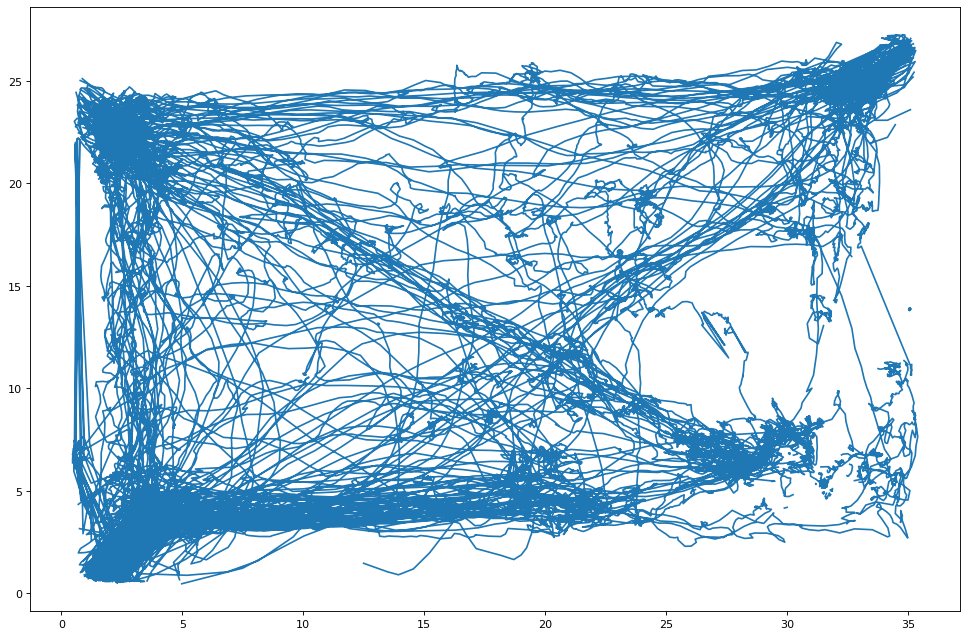

In [6]:
# choose the dam (int between 0 and 4)
Example=4

# Get data for this dam
ExampleSessionCentroid=  [f for f in os.listdir(Path_Files+SessionsToRun[Example]) if f.startswith('centroid')] 
ExampleSessionTTL= [f for f in os.listdir(Path_Files+SessionsToRun[Example]) if f.startswith('Playback_TTL')] 
tracking=np.genfromtxt([Path_Files+SessionsToRun[Example]+ '/'  +ExampleSessionCentroid[0]][0], delimiter=',')
TTL=np.genfromtxt([Path_Files+SessionsToRun[Example]+ '/' +ExampleSessionTTL[0]][0], delimiter=',')

#Rescaling from pixels to cm
Scale=8.8
tracking=tracking/Scale

if np.size(tracking,0)!=np.size(TTL):
    minimum=np.min([np.size(tracking,0),np.size(TTL)])
    TTL=TTL[0:minimum]
    tracking=tracking[0:minimum,:]
    print(minimum)

# plot the dam's centroid during session
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(tracking[:,0], tracking[:,1])
plt.show()

## Handle TTL pulses

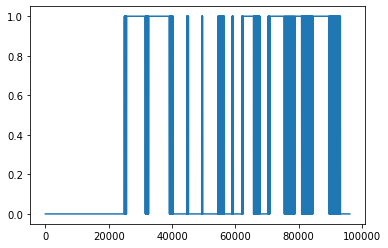

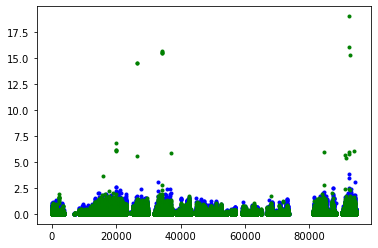

In [7]:
#Threshold and redefine TTL
TTL[:]=TTL>1
plt.plot(TTL[:])
plt.show()

#Define DiffTTL
DiffTTL= np.diff(TTL)
DiffTTL=np.append(DiffTTL,DiffTTL[-1])

#Get TTL flips
HighFlips=np.where(DiffTTL>0.5)
DiffFlips=np.diff(HighFlips)
DiffFlips=np.append(DiffFlips[0],DiffFlips[0][-1])
CryFlips=( DiffFlips> 28) & (DiffFlips < 32)
USVFlips=( DiffFlips> 88) & (DiffFlips < 92)
EndFlips=( DiffFlips> 95)
allVector=np.arange(0,np.size(TTL,0),1)
AllCry=np.interp(allVector, HighFlips[0], CryFlips)
AllUSV=np.interp(allVector, HighFlips[0], USVFlips)
AllUSV[allVector<HighFlips[0][0]]=False
AllCry[allVector<HighFlips[0][0]]=False
AllUSV[allVector>HighFlips[0][-1]]=False
AllCry[allVector>HighFlips[0][-1]]=False
AllCrybool=AllCry==1
AllUSVbool=AllUSV==1

#Remove jumps in tracking and interpolating tracking
diffX=np.diff(tracking[:,0])
diffY=np.diff(tracking[:,1])
diffX=np.append(diffX,diffX[-1])
diffY=np.append(diffY,diffY[-1])
plt.plot (np.abs(diffX), '.b')
plt.plot (np.abs(diffY), '.g')
EraseX=np.where(np.abs(diffX)>1.3)
EraseY=np.where(np.abs(diffY)>1.3)
Erase=np.append(EraseX, EraseY)
Erase=np.unique(Erase)

#Erase outliers
tracking[Erase,:] = np.NAN
diffX=np.diff(tracking[:,0])
diffY=np.diff(tracking[:,1])
diffX=np.append(diffX,diffX[-1])
diffY=np.append(diffY,diffY[-1])

#interpolate nans
NaNIndexes=np.where(np.isnan(tracking[:,0]))
tracking[NaNIndexes,0]=np.interp(NaNIndexes[0],np.where(~np.isnan(tracking[:,0]))[0],tracking[np.where(~np.isnan(tracking[:,0])),0][0])
tracking[NaNIndexes,1]=np.interp(NaNIndexes[0],np.where(~np.isnan(tracking[:,1]))[0],tracking[np.where(~np.isnan(tracking[:,1])),1][0])

## plot centroid labeled by playback type (Figure 2C)

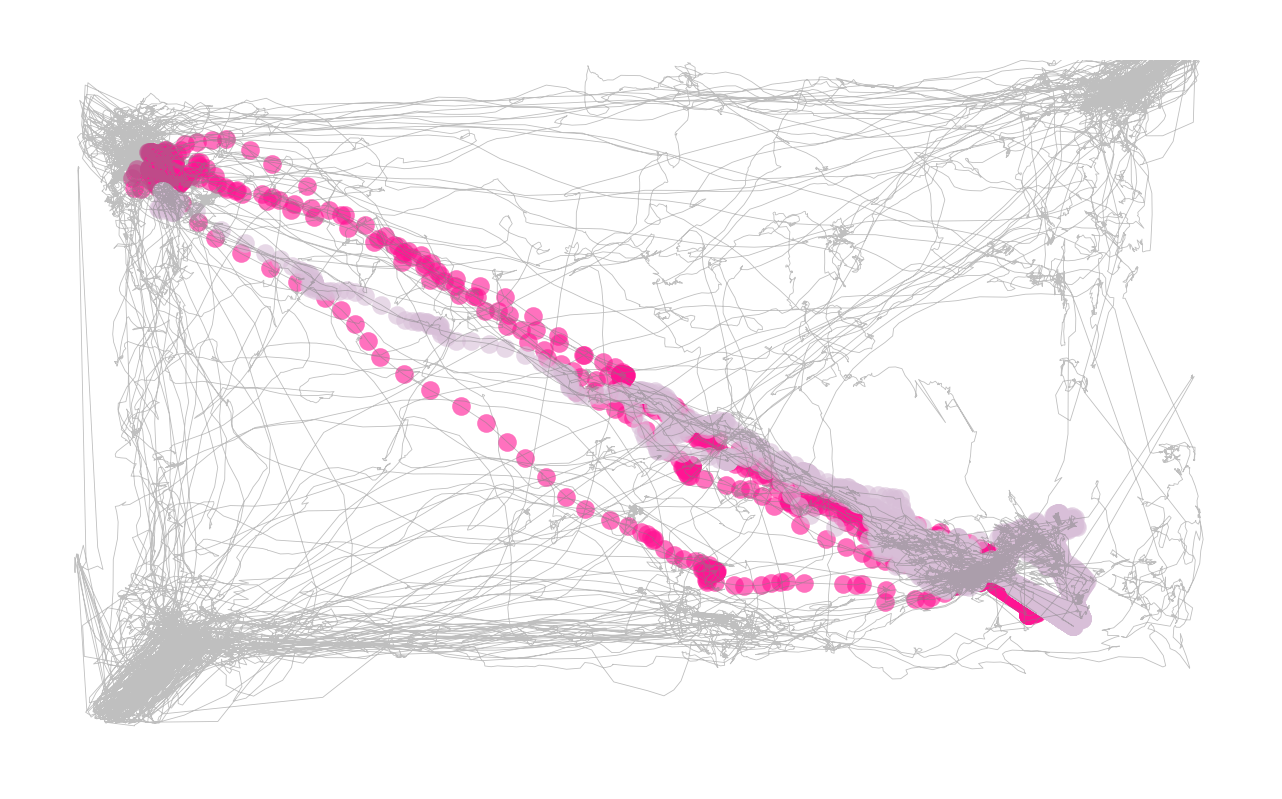

In [8]:
save =False

####################################################################################################

plt.figure(figsize = [2.5,1.5], dpi = 600)

no_playback_alpha = .5
playback_alpha = .6
no_playback_s = 2.5
playback_s = 5
fontsize = 9

#Plotting all tracking and differentially tracking under Cry or USV
#print(HighFlips[0][CryFlips])
plt.plot( tracking[0:75000,0], 
            tracking[0:75000,1], 
            color='grey', 
            alpha=no_playback_alpha, linewidth=.1)

AllCryIndex=np.where(AllCrybool[0:75000]==True)
AllUSVIndex=np.where(AllUSVbool[0:75000]==True)


plt.scatter(tracking[AllCryIndex,0], 
            tracking[AllCryIndex,1], 
            color='deeppink', 
            alpha = playback_alpha, 
            s = playback_s, 
            linewidth=0)

plt.scatter(tracking[AllUSVIndex,0], 
            tracking[AllUSVIndex,1], 
            color='thistle', 
            alpha = playback_alpha, 
            linewidth=0,
            s = playback_s)

plt.xlabel('X position (cm)', fontname="Arial", fontsize=fontsize)
plt.ylabel('Y position (cm)',  fontname="Arial", fontsize=fontsize)

plt.xlim(0,36)
plt.ylim(0,26)

plt.xlabel('')
plt.ylabel('')

plt.xticks([],[])
plt.yticks([],[])

plt.axis('off')
sns.despine()
#plt.plot(tracking[HighFlips[0][EndFlips],0], tracking[HighFlips[0][EndFlips],1], '.m' )

if save:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_3/'
    save_name = 'dam_5_example_position_plot_v2.jpeg'
    plt.savefig(os.path.join(save_dir,save_name), bbox_inches = 'tight', dpi=600)


## plot distance to speaker colored by mouse speed (overlay playback and type)

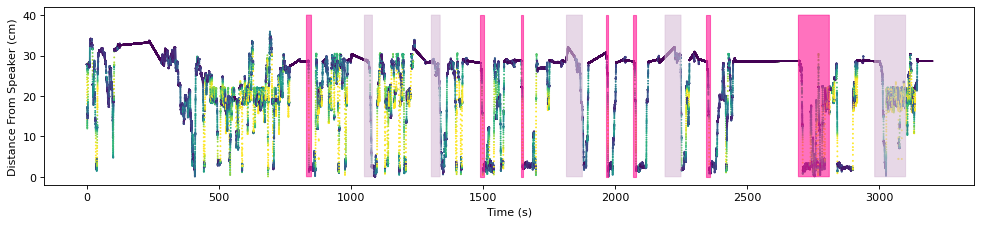

In [9]:
#get distances
Begin=0
Ending=np.size(TTL,0)
DiffTTL= np.diff(TTL)
DiffTTL=np.append(DiffTTL,DiffTTL[-1])
DistanceMouseSpeaker=beh.calc_distance(tracking[:,0], tracking[:,1], 5, 22.5)
DistanceMouseNest=beh.calc_distance(tracking[:,0], tracking[:,1], 31, 6)

#process
TimeVector=np.arange(0,0.0333*np.size(TTL,0),0.0333)
Speedpre=beh.calc_speed(tracking, 30)
Speedpre=np.append(Speedpre,Speedpre[-1])
Filter=beh.gaussian_filter_1d(size=60,sigma=5)
Speed=np.convolve(Speedpre, Filter, 'same')

#plot
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax= plt.subplot(3,1,1)
plt.scatter( TimeVector[Begin:Ending], DistanceMouseSpeaker[Begin:Ending],c=Speed[Begin:Ending], s=.5, alpha=1,  vmin=0, vmax=20)
plt.xlabel('Time')
plt.ylabel('Distance to Speaker')
ax.fill_between(TimeVector,0,40, where=AllCrybool,  alpha=0.6, color='deeppink')
ax.fill_between(TimeVector,0,40, where=AllUSVbool,  alpha=0.6, color='thistle')
plt.xlabel('Time (s)')
plt.ylabel('Distance From Speaker (cm)')
plt.rcParams.update({'font.size': 15})

plt.show()

# Get data for all dams

In [10]:
DataframePlayback = beh.get_data(Path_Files, save=False, save_dir=None)

Aggregating data from dams (species_ID_yyyy_m_dd):

	 BW_f_29483_2022_7_15
	 BW_f_28988_2022_3_16
	 BW_f_29916_2022_2_23
	 BW_f_29915_2022_3_03
	 BW_f_31922_2022_3_01
done.


# plotting

## distance to speaker with playback time and type (Figure 2D)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


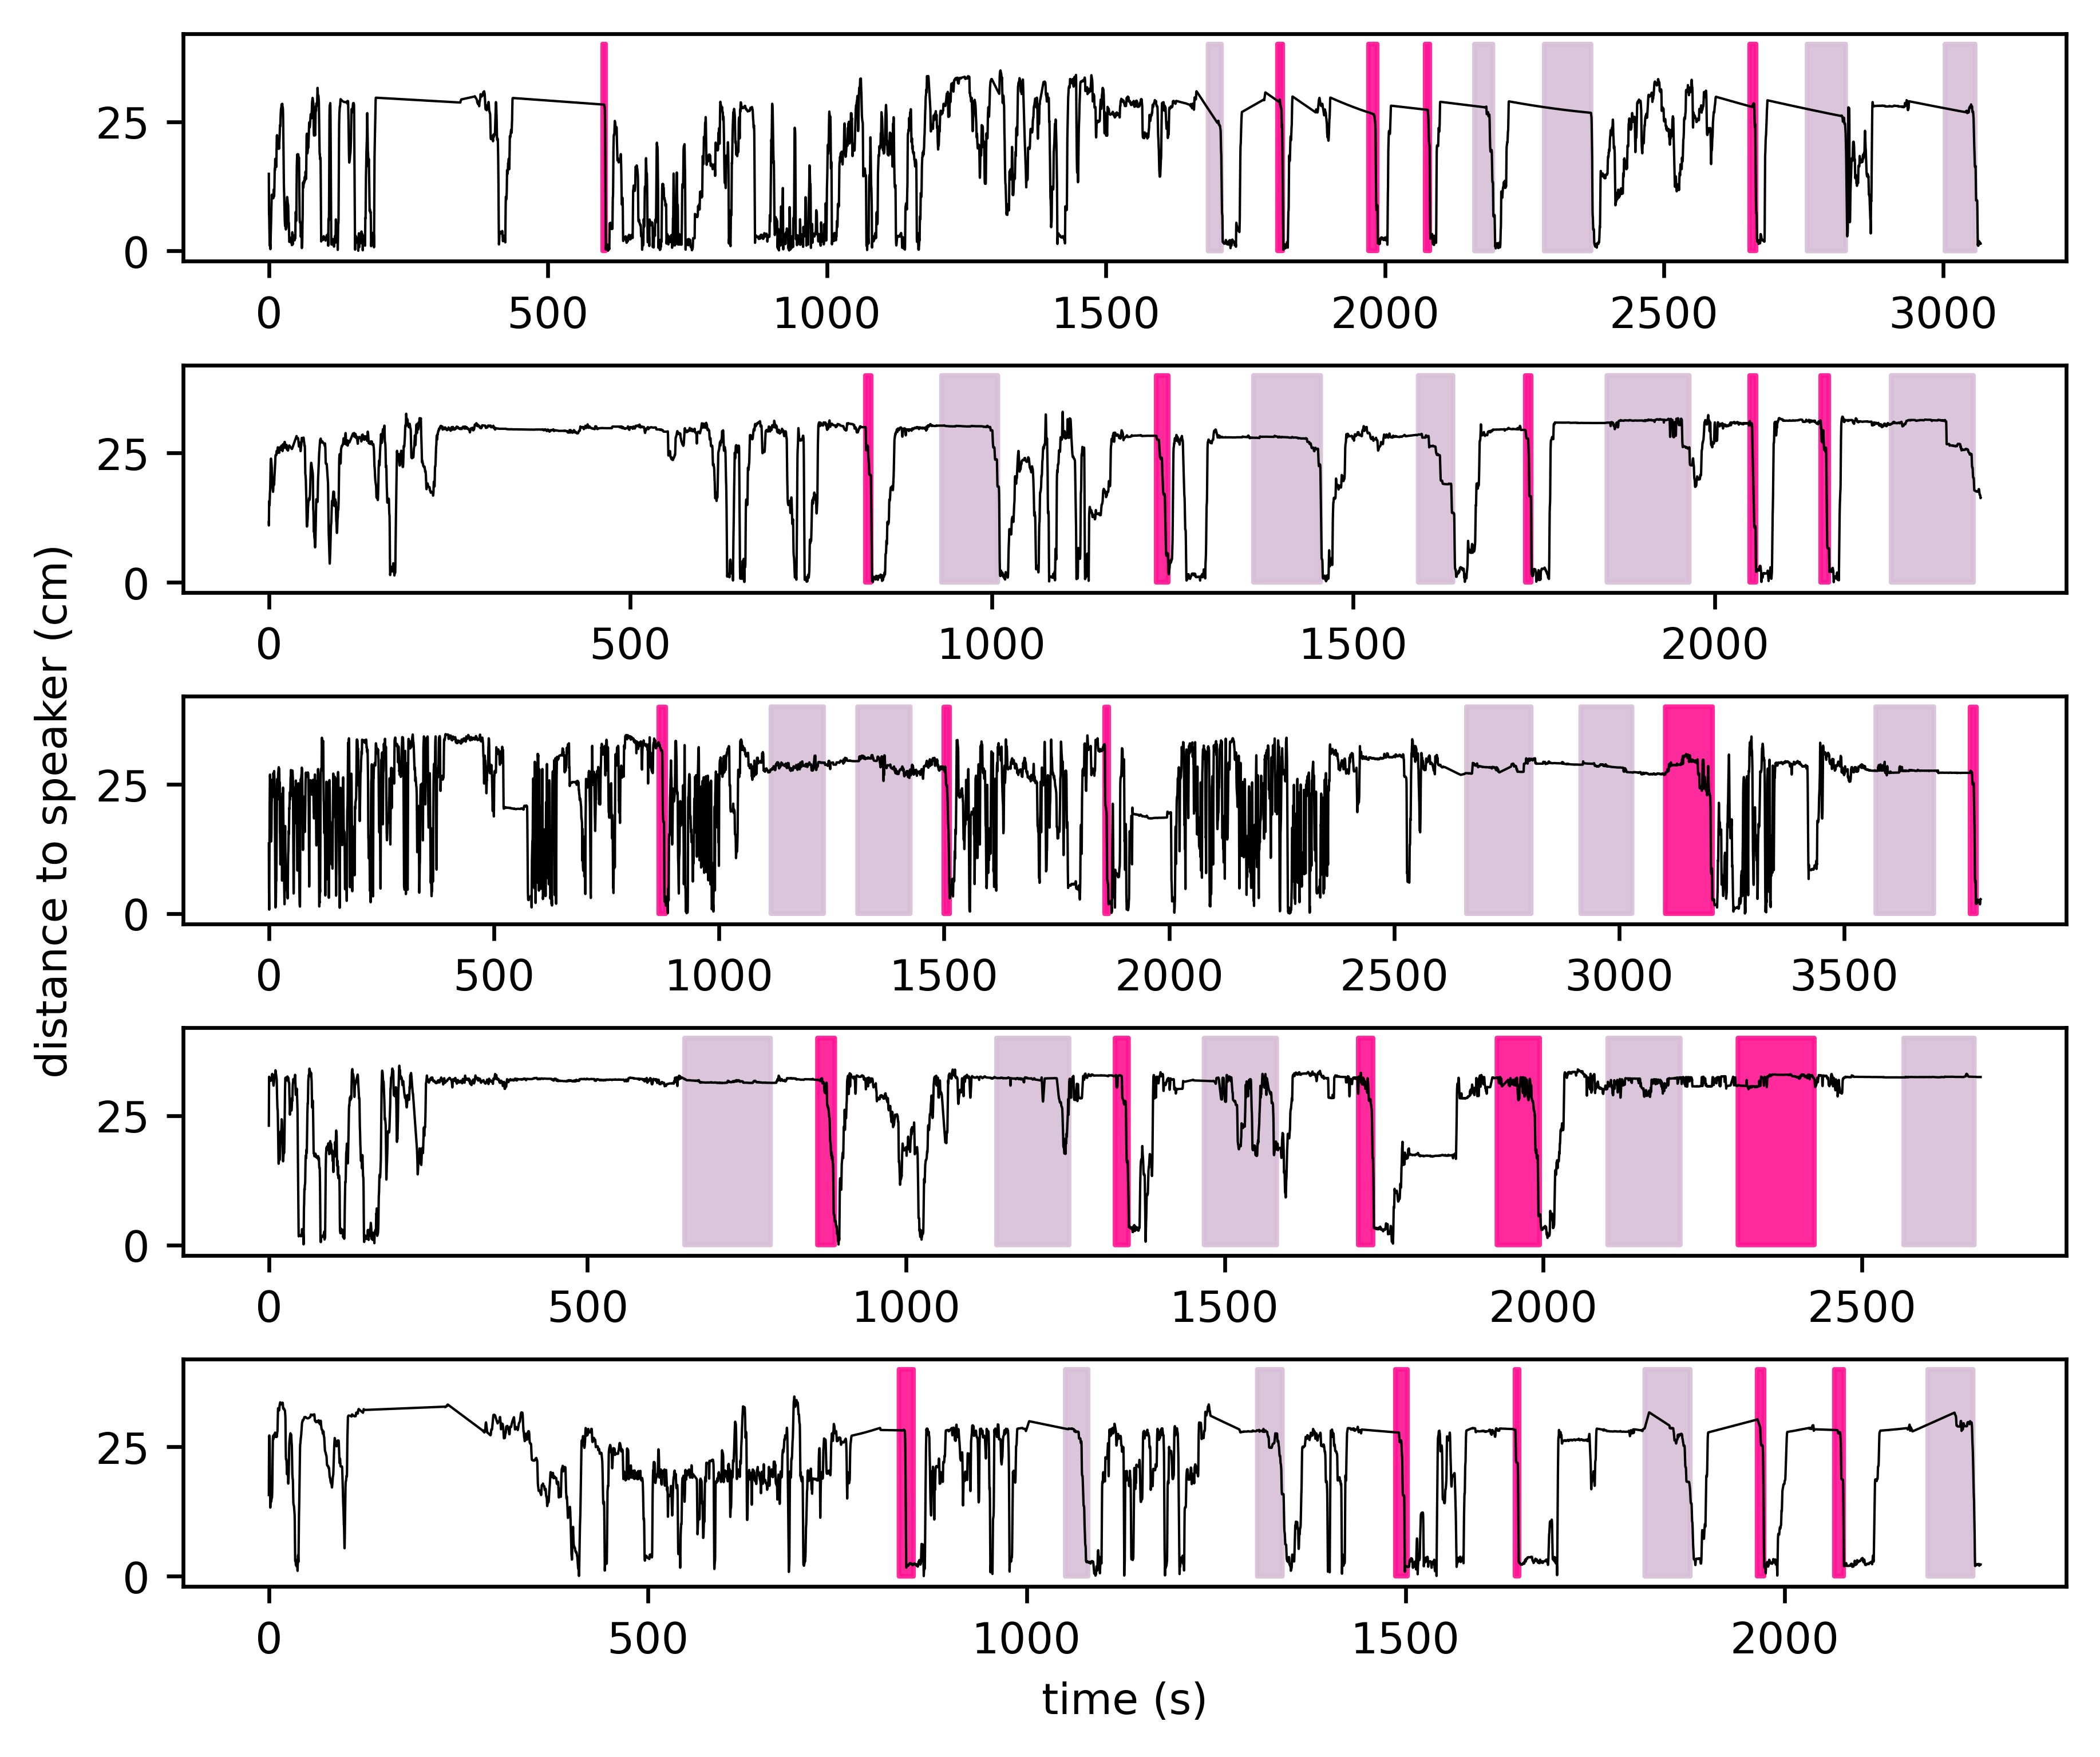

In [11]:
fontsize = 9

#####################################################################################################################

#set up figure
figure(num=None, figsize=(6, 5), 
       dpi=600, 
       facecolor='w', 
       edgecolor='black', constrained_layout=True)
plt.rcParams.update({'font.size': fontsize})
plotindex=1

#iteratre through dams (sessions) and plot
for identity in DataframePlayback["id"]:

    EndOfExp=DataframePlayback.loc[DataframePlayback["id"]==identity, "end_experiment"].item()
    ax=plt.subplot(5,1,plotindex)

    plt.plot(DataframePlayback.loc[DataframePlayback["id"]==identity, "time_vector"].to_numpy()[0][0:EndOfExp],
             DataframePlayback.loc[DataframePlayback["id"]==identity, "distance_to_speaker"].to_numpy()[0][0:EndOfExp],
             color="black", 
             linewidth=0.5)
    ax.fill_between(DataframePlayback.loc[DataframePlayback["id"]==identity, "time_vector"].to_numpy()[0][0:EndOfExp],
                    0,
                    40, 
                    where=DataframePlayback.loc[DataframePlayback["id"]==identity, "all_cry_bool"].to_numpy()[0][0:EndOfExp],  
                    alpha=0.9, 
                    color='deeppink')
    ax.fill_between(DataframePlayback.loc[DataframePlayback["id"]==identity, "time_vector"].to_numpy()[0][0:EndOfExp],
                    0,
                    40, 
                    where=DataframePlayback.loc[DataframePlayback["id"]==identity, "all_USV_bool"].to_numpy()[0][0:EndOfExp],  
                    alpha=0.9, 
                    color='thistle')
    
    
    
    if plotindex==3:
        plt.ylabel('distance to speaker (cm)', fontname="Arial", fontsize=fontsize)  
        
    if plotindex!=5:
        plt.xlabel('')
    elif plotindex==5:
        plt.xlabel('time (s)', fontname="Arial", fontsize=fontsize)
        
    plotindex=plotindex+1

plt.show()


## distance to speaker heatmaps (Figure 2E)

([], [])

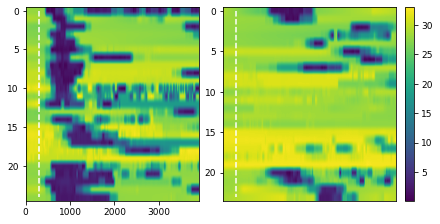

In [12]:
# hard code information that is the same for all playback trials
start=0
TotalTime=3900
PreTime=300
iterations=25

#get the heatmap matrices from the playback dataframe
CryMatrix, USVMatrix = beh.get_heatmaps(playback_df=DataframePlayback, 
                                        feature="distance_to_speaker")

#plot
plt.figure(figsize=[6,3], 
           constrained_layout=True)

#plot cries
plt.subplot(1,2,1)
plt.imshow(CryMatrix, aspect='auto', cmap='viridis')
plt.vlines(PreTime,0,24, 'w', linestyle = '--')

#plot USV
plt.subplot(1,2,2)
plt.imshow(USVMatrix, aspect='auto', cmap='viridis')
plt.vlines(PreTime,0,23, 'w', linestyle = '--')
cbar=plt.colorbar()

plt.xticks([],[])

## connected dot plots (Figure 2F)

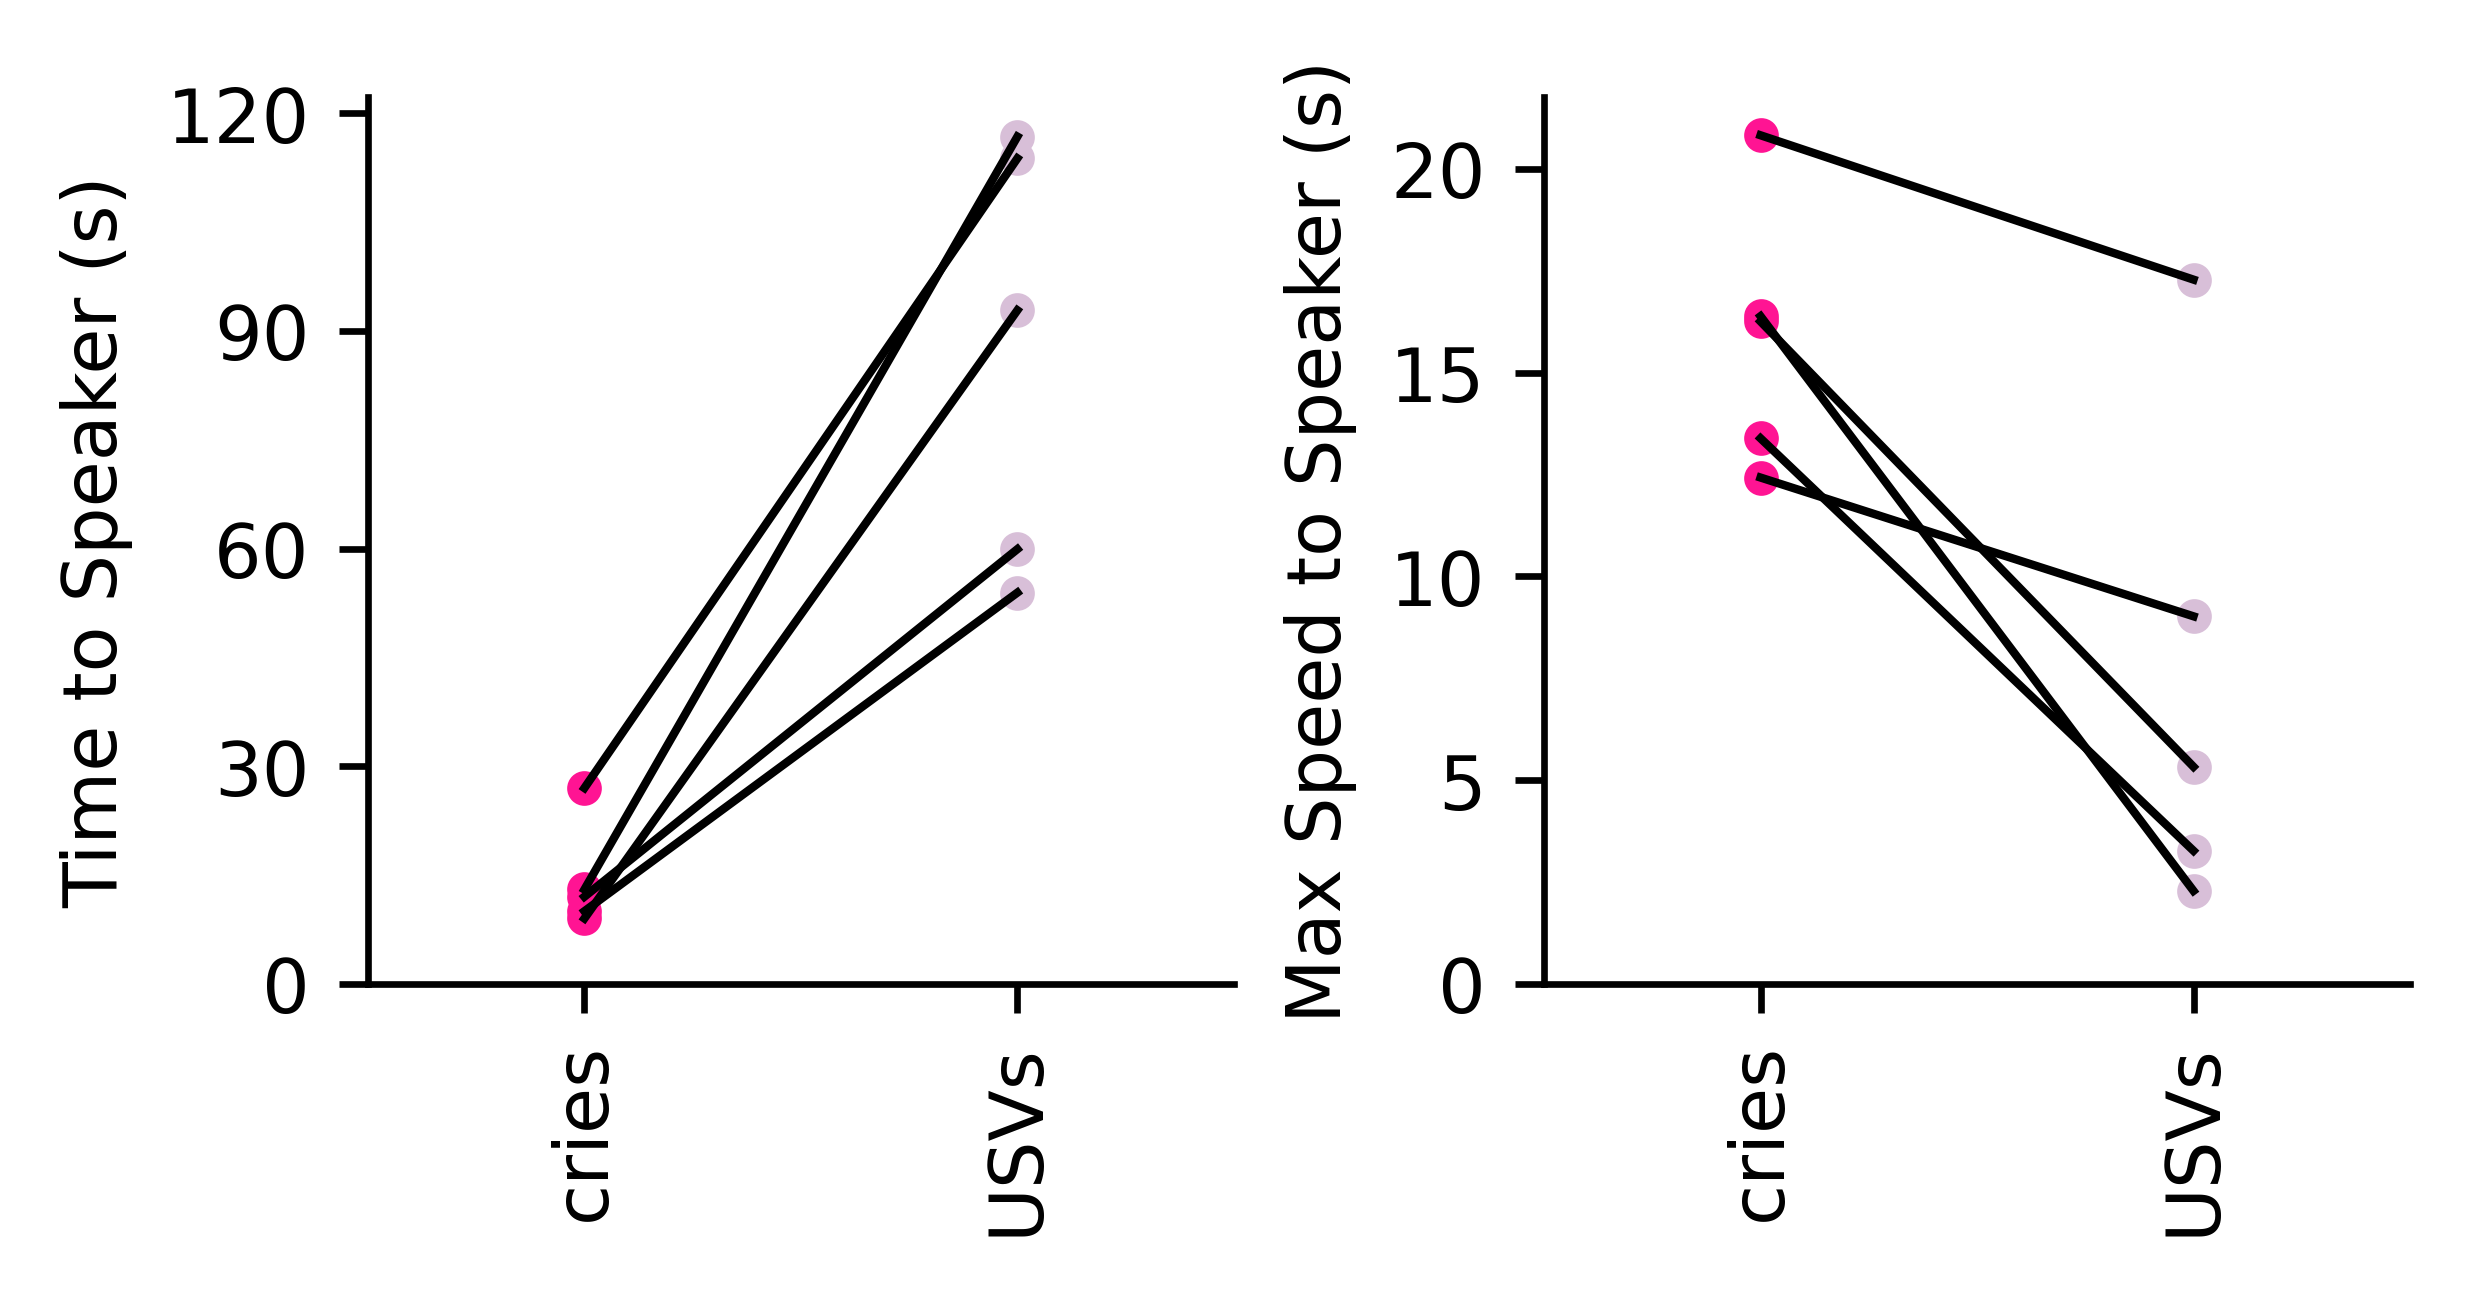

In [13]:

save= False

#####################################################################################################################

# set up the figure
fig, axes = plt.subplots(ncols = 2, 
                         nrows = 1, 
                         figsize=[4,2], 
                         constrained_layout = True, 
                         dpi = 600)

#plot median_time (median time to speaker) from DataframePlayback
feature = 'median_time_'

if feature == 'median_time_':
    y_ticks = [0,30,60,90,120]

elif feature == 'max_speed_':
    y_ticks = [0,5,10,15,20]

# plot the lines
for i in range(len(DataframePlayback[[ feature+"USV"]])):
    axes[0].plot( [0,1], [DataframePlayback[[feature+"cry"]].iloc[i], DataframePlayback[[feature+"USV"]].iloc[i]], c='black', alpha=1, linewidth=1)

# plot the points
axes[0].scatter(np.zeros(len(DataframePlayback[[feature+"cry"]])), DataframePlayback[[feature+"cry"]], color='deeppink', s=10, alpha=1)
axes[0].scatter(np.ones(len(DataframePlayback[[ feature+"USV"]])), DataframePlayback[[ feature+"USV"]], color='thistle', s=10 , alpha=1)
    
axes[0].set_xticks([0,1], ["cries", "USVs"],   fontname="Arial", fontsize=9, rotation=90)
axes[0].set_yticks(y_ticks, fontname="Arial", fontsize=9)
axes[0].set_ylabel('Time to Speaker (s)',   fontname="Arial", fontsize=9)
axes[0].set_xlim(-0.5,1.5)

sns.despine()

#plot max_speed_ (median of maximum speed achieved while going to speaker) from DataframePlayback
feature = 'max_speed_'

if feature == 'time_median_':
    y_ticks = [0,30,60,90,120]

elif feature == 'max_speed_':
    y_ticks = [0,5,10,15,20]

# plot the lines
for i in range(len(DataframePlayback[[ feature+"USV"]])):
    axes[1].plot( [0,1], [DataframePlayback[[feature+"cry"]].iloc[i], DataframePlayback[[feature+"USV"]].iloc[i]], c='black', alpha=1, linewidth=1)

# plot the points
axes[1].scatter(np.zeros(len(DataframePlayback[[feature+"cry"]])), DataframePlayback[[feature+"cry"]], color='deeppink', s=10, alpha=1)
axes[1].scatter(np.ones(len(DataframePlayback[[ feature+"USV"]])), DataframePlayback[[ feature+"USV"]], color='thistle', s=10 , alpha=1)
    
axes[1].set_xticks([0,1], ["cries", "USVs"],   fontname="Arial", fontsize=9, rotation=90)
axes[1].set_yticks(y_ticks, fontname="Arial", fontsize=9)
axes[1].set_ylabel('Max Speed to Speaker (s)',   fontname="Arial", fontsize=9)
axes[1].set_xlim(-0.5,1.5)

sns.despine()


In [17]:
# save

save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/resubmission/figure_3/'
save_name = 'playback_data.csv'
DataframePlayback.to_csv(os.path.join(save_dir, save_name), index=False)

## statistics (use R kernel)

In [6]:
#paths to data
playback.data.path <- "/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/resubmission/figure_3/playback_data.csv"
playback.data <- read.csv(playback.data.path)


In [16]:
#t-test of speed
t.test(playback.data$max_speed_cry, playback.data$max_speed_USV, paired = TRUE, alternative = "two.sided")


	Paired t-test

data:  playback.data$max_speed_cry and playback.data$max_speed_USV
t = 3.9599, df = 4, p-value = 0.01668
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
  2.516302 14.322767
sample estimates:
mean difference 
       8.419535 


In [17]:
#t-test of time
t.test(playback.data$median_time_cry, playback.data$median_time_USV, paired = TRUE, alternative = "two.sided")


	Paired t-test

data:  playback.data$median_time_cry and playback.data$median_time_USV
t = -6.2692, df = 4, p-value = 0.003304
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -105.70484  -40.81516
sample estimates:
mean difference 
         -73.26 
